In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import statistics as stat
from scipy import stats
import glob
import os
import pandas as pd
from datetime import datetime
from scipy import signal
from numpy.random import default_rng
from scipy.signal import correlate


import seaborn as sns
import scipy.stats as stats
sns.set_context('talk',font_scale=.8)

show missing data in eyelink dataset


No handles with labels found to put in legend.


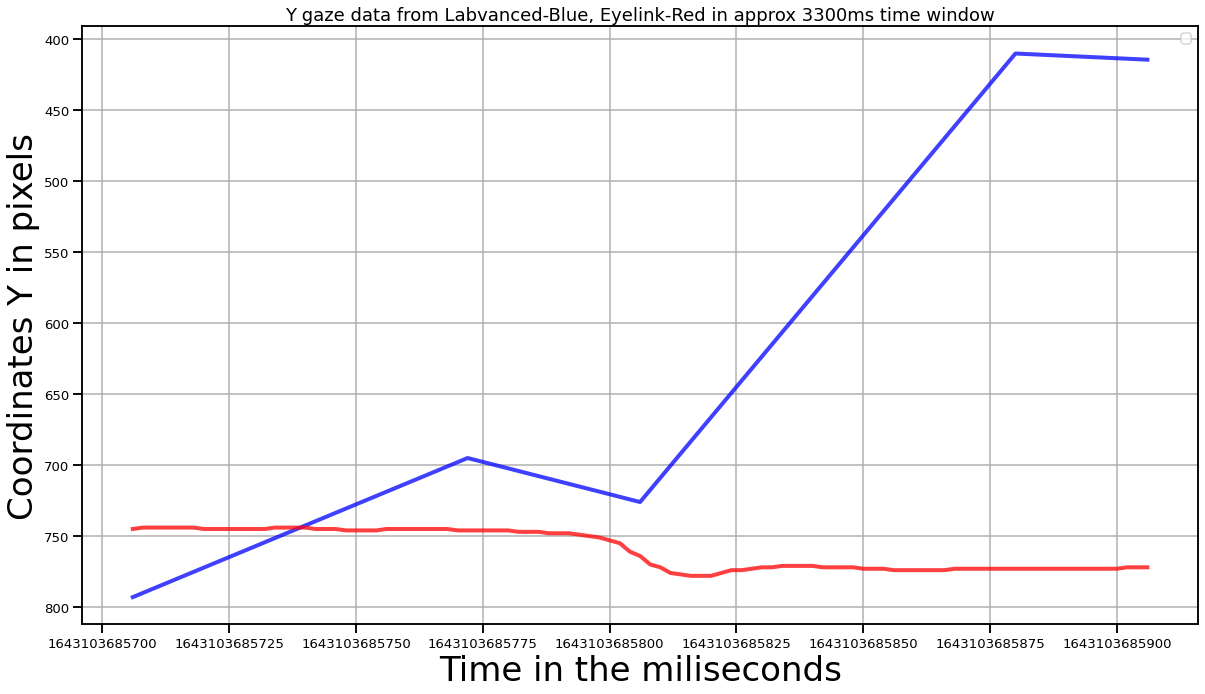

No handles with labels found to put in legend.


p3Blue Line represent timeseries data from Labvanced, the red line represents 
Eyelink and dotted black line represents data after lag cross-correlation corrections.


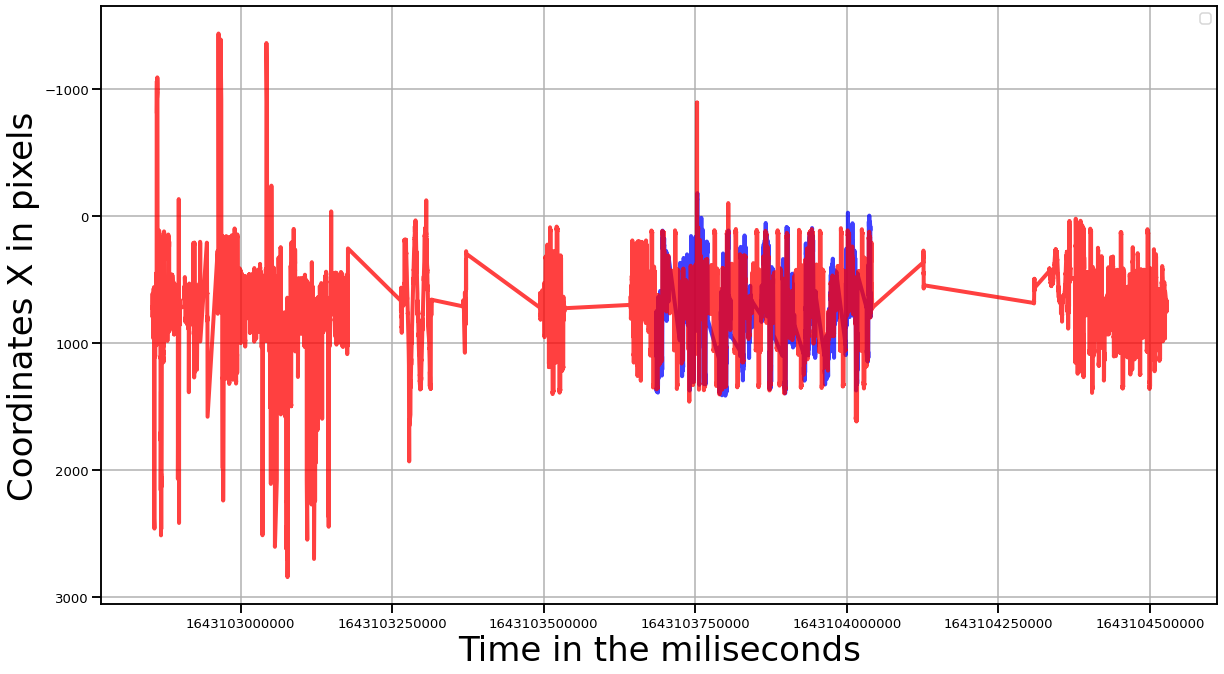

In [2]:
counter = 14
offsetMedianArr = []
# for files in sorted(glob.glob("../data/lb_data/timeseries_data/*.csv"),key=os.path.getmtime):
#     lb_data = files  
# for files in sorted(glob.glob("../data/el_data/*.csv"),key=os.path.getmtime):
#     el_data = files  
#     counter = counter + 1
    # print(counter)
for i in range(3,counter):
    lb = pd.read_csv('../data/lb_data/timeseries_data/p' + str(i) + '_XYTC.csv')

    el = pd.read_csv('../data/el_data/test/p'+ str(i) +'.csv')
    
    def formating_labvanced (lb):

        lb = lb[lb['Task_Name'] == "large_grid"]
        # lb = lb[lb['variable_name'] == "XYTC"]
        # df.rename(columns={"A": "a", "B": "c"})
        lb = lb.rename(columns={"value":"X_lb","Unnamed: 11":"Y_lb","Unnamed: 12":"time_lb","Unnamed: 13":'c'})
        # print(lb.mean())
        # lb['time_lb'] = lb['time_lb'] - 563
        # Format time column
        lb['time_lb'] = lb['time_lb'].fillna(0)
        lb = lb[(lb[['time_lb']] != 0).all(axis=1)]


        # lb['time_lb'] = lb['time_lb'].fillna(0)
        # lb = lb[(lb[['time_lb']] != 0).all(axis=1)]
        lb.time_lb = lb.time_lb.apply(lambda x: int('%.0f' % x))

        # # Sort data towards the time column
        # lb.sort_values('time_lb', inplace=True)

        # # Fill all nan values with 0
        lb[['X_lb','Y_lb']] = lb[['X_lb','Y_lb']].fillna(0)

        # # Convert the coordinates points from floats to intergers
        lb[['X_lb','Y_lb']] = lb[['X_lb','Y_lb']].apply(np.int64)
        lb = lb[(lb[['X_lb']] != 0).all(axis=1)]

        return lb
    def formating_eyelink (el):
        el.Time = el.Time.apply(lambda x: int('%.0f' % (x * 1)))
        # el['Time'] = el['Time'].apply(np.int64) * 1000
        # EYE LINK DATA rename the eyelink columns
        el = el.rename(columns={'X':'X_el','Y':'Y_el','Time':'t'})
        el['time_el'] = el['t']
        #If so delete this row
        el = el[(el[['X_el','Y_el','time_el']] != 0).all(axis=1)]
        el.dropna(inplace=True)
        #Check once agian
        print('show missing data in eyelink dataset')
        (el == 0).sum(axis=0)


        return el
    lb = formating_labvanced (lb)
    el = formating_eyelink (el)
#     break

    
    
    # 1.Resample data to 500Hz to have equal sample size
    # First to use resmaple function I have to change the unix timestamp (int) to datatime format
    lb['time_lb'] = pd.to_datetime(lb["time_lb"], unit='ms')
    # Then change index to converted column and use the function using mean value to resample from 30hz up to 500hz
    lb = lb.set_index('time_lb')
    # 500hz is 2ms
    lb = lb.resample('2ms').interpolate()
    # Reconvert from datatime to unix timestamp
    lb.index = lb.index.astype('int64') // 10** 6
    
    # Prepare Eyelink data by changing the index to merge two dataframes
    el = el.set_index('t')
    
    def interpolation ():
    # Interpolate data to have equal index size

        df_temp = pd.concat([el, lb .index.to_frame()]).sort_index().interpolate()

        df_temp = df_temp[~df_temp.index.duplicated(keep='first')]
        df_interpolated = lb .merge(df_temp, left_index=True, right_index=True, how='left')

        df_interpolated = df_interpolated.drop(columns=['time_lb'])
        df_interpolated = df_interpolated.reset_index()

        df_interpolated .Y_el = df_interpolated.Y_el.astype(int)
        df_interpolated .X_el = df_interpolated.X_el.astype(int)
        return df_interpolated
    df_interpolated = interpolation()
    
    first_4k_miliseconds = df_interpolated.loc[0:100]
#     df = first_4k_miliseconds[['Y_lb','Y_el']]
    # df['diff'] = df.time_lb.diff().fillna(0)
    # df = df.set_index('diff')

    correlation = signal.correlate(df_interpolated.Y_el,df_interpolated.Y_lb,mode='same')
    delay = np.argmax(correlation)-int(len(correlation)/2)
#     break
# print("delay betwen two signals for first paricipant is" + str(delay))
#     labvanced_time = first_4k_miliseconds['time_lb']
#     eyelink_time = first_4k_miliseconds['time_el']
#     correlation = signal.correlate(labvanced_time, eyelink_time, mode="same")
#     time_lags = signal.correlation_lags(labvanced_time.size, eyelink_time.size, mode="same")
#     time_lags
    
#     labvanced_coor = first_4k_miliseconds['Y_lb']
#     eyelink_coor = first_4k_miliseconds['Y_el']
#     correlation = signal.correlate(labvanced_coor, eyelink_coor, mode="same")
#     spatcial_lags = signal.correlation_lags(labvanced_coor.size, eyelink_coor.size, mode="same")
#     spatcial_lags
    
#     corr_coeff_coordinates = labvanced_coor.corr(eyelink_coor)
#     print('coorleation for coordinates y')
#     corr_coeff_coordinates
    
#     corr_coeff_time = labvanced_time.corr(eyelink_time)
#     print('coorleation for time values')
#     corr_coeff_time
    
#     corr_cordinates = first_4k_miliseconds.Y_el - spatcial_lags
    
    


#     overall_pearson_r = df.corr().iloc[0,1]
#     print(f"Pandas computed Pearson r: {overall_pearson_r:.3g}")

#     r, p = stats.pearsonr(df.dropna()['Y_el'], df.dropna()['Y_lb'])
#     print(f"Scipy computed Pearson r: {r:.3g} and p-value: {p:.3g}")

#     f,ax=plt.subplots(figsize=(14,3))
#     df.rolling(window=30,center=True).median().plot(ax=ax)
#     ax.set(xlabel='Gaze Data Samples',ylabel='Coordinates Values',title=f"Overall Pearson r = {overall_pearson_r:.2g}");
    
#     def crosscorr(datax, datay, lag=0, wrap=False):
#         """ Lag-N cross correlation. 
#         Shifted data filled with NaNs 

#         Parameters
#         ----------
#         lag : int, default 0
#         datax, datay : pandas.Series objects of equal length
#         Returns
#         ----------
#         crosscorr : float
#         """
#         if wrap:
#             shiftedy = datay.shift(lag)
#             shiftedy.iloc[:lag] = datay.iloc[-lag:].values
#             return datax.corr(shiftedy)
#         else: 
#             return datax.corr(datay.shift(lag))

#     def slidingWindowCrossCorr (df):
#         print('running Time Lagged Cross Correlation — assessing signal dynamics')
#         d1 = df['Y_lb']
#         d2 = df['Y_el']
#         ms = 1
#         gaze_samples = 30
#         rs = [crosscorr(d1,d2, lag) for lag in range(-int(ms*gaze_samples),int(ms*gaze_samples+1))]
#         offset = np.floor(len(rs)/2)-np.argmax(rs)
#         f,ax=plt.subplots(figsize=(14,3))
#         ax.plot(rs)
#         ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
#         ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
#         ax.set(title=f'Offset = {offset} gaze samples \Y_lb leads <> Y_el leads', xlabel='Offset',ylabel='Pearson r')
#         # # ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#         ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
#         plt.savefig('./synchronization_graphs/TLCC_lag_show/TLCC' + str(df.tail(1).index[0] + 1) + 'p' + str(i) + '.jpg')
#         offset = offset
#         plt.legend()
#         return offset
#     offsetsArr = []
#     offset = int(slidingWindowCrossCorr(df_interpolated[0:100]))
#     offsetsArr.append(offset)
#     print(offsetsArr)

#     offset = int(slidingWindowCrossCorr(df_interpolated[100:200]))
#     offsetsArr.append(offset)
#     print(offsetsArr)

#     offset = int(slidingWindowCrossCorr(df_interpolated[200:300]))
#     offsetsArr.append(offset)
#     print(offsetsArr)

#     offset = int(slidingWindowCrossCorr(df_interpolated[300:400]))
#     offsetsArr.append(offset)
#     print(offsetsArr)

#     offset = int(slidingWindowCrossCorr(df_interpolated[400:500]))
#     offsetsArr.append(offset)
#     print(offsetsArr)

#     offset = stat.median(offsetsArr)
#     offsetMedianArr.append(offset)

#     # sig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)
#     # sig_noise = sig + rng.standard_normal(len(sig))
#     # corr = signal.correlate(sig_noise, np.ones(128), mode='same') / 128

#     corr = signal.correlate(df['Y_lb'], df['Y_el'], mode='same')


#     clock = [10,20,30,40,50,60,70,80,90,100]
#     clock
#     fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True, figsize=(15,15))
#     ax_orig.plot(df['Y_el'])
#     # ax_orig.plot(clock, sig[clock], 'ro')
#     ax_orig.set_title('Y_el')
#     ax_noise.plot(df['Y_lb'])
#     ax_noise.set_title('Y_lb')
#     ax_corr.plot(corr)
#     ax_corr.plot(clock, corr[clock], 'ro')
#     ax_corr.axhline(0.5, ls=':')
#     ax_corr.set_title('Cross-correlated with rectangular pulse')
#     ax_orig.margins(0, 0.1)
#     fig.tight_layout()
#     plt.show()
    
#     x = np.arange(128) / 128
#     sig = df['Y_el']
#     sig_noise = df['Y_lb']
#     corr = signal.correlate(sig_noise, sig)
#     lags = signal.correlation_lags(len(sig), len(sig_noise))
    
#     coorection = False
    
#     # SCIPY FUNCTION:
#     def useScipyCrossCorr(df):
#         from scipy import signal
#         x = df['Y_lb']
#         y = df['Y_el']
#         correlation = signal.correlate(x, y, mode="same")
#         lags = signal.correlation_lags(x.size, y.size, mode="same")
#         lag = lags[np.argmax(correlation)]
#         return correlation
    
    
#     lag = useScipyCrossCorr(df_interpolated[0:500])
 
    def timeSeriesSyncPlot (time_lb, coor_lb, coor_el):
        x1 = time_lb
        y1 = coor_lb

        x2 = time_lb
        y2 = coor_el


        # plot
        plt.legend()
        plt.xlabel('Time in the miliseconds', fontsize=34)
        plt.ylabel('Coordinates Y in pixels', fontsize=34)
        plt.plot(x1,y1, c='b', label='Labvanced', linewidth=4, alpha=0.75)
        plt.plot(x2,y2, c='r', label='EyeLink', linewidth=4, alpha=0.75)
    #     plt.plot(x3,y3, c='black', label='EyeLink', linewidth=4, alpha=0.75, linestyle = 'dotted')
        # plt.legend(loc='upper left')
        # plt.gcf().autofmt_xdate()
        plt.gcf().set_size_inches((20, 11))
        # ALWAYS FLIP y AXIS!!!!!!!!!!!!!!!
        plt.gca().invert_yaxis()
        plt.ticklabel_format(useOffset=False)
        plt.ticklabel_format(useOffset=False, style='plain')
        coorection=False
        if(coorection == False):
            plt.title('Y gaze data from Labvanced-Blue, Eyelink-Red in approx 3300ms time window',fontsize=18)
            plt.savefig('./synchronization_graphs/sync_before_xcorr/sync_before_correlation' + str(i) + '.jpg')
        else:
            plt.title('Y gaze data from Labvanced-Blue, Eyelink-Red in approx 3300ms time window',fontsize=18)
            plt.savefig('./synchronization_graphs/sync_after_xcorr/sync_after_correlation' + str(i) + '.jpg')
        plt.grid()
        plt.show()
        print('p' + str(i) + 'Blue Line represent timeseries data from Labvanced, the red line represents \nEyelink and dotted black line represents data after lag cross-correlation corrections.')
        
        
    timeSeriesSyncPlot(first_4k_miliseconds.time_lb, first_4k_miliseconds.Y_lb, first_4k_miliseconds.Y_el)
    x1 = df_interpolated.time_lb
    y1 = df_interpolated.X_lb

    x2 = el.time_el
    y2 = el.X_el
    # 
    # plot
    plt.legend()
    plt.xlabel('Time in the miliseconds', fontsize=34)
    plt.ylabel('Coordinates X in pixels', fontsize=34)
    plt.plot(x1,y1, c='b', label='Labvanced', linewidth=4, alpha=0.75)
    plt.plot(x2,y2, c='r', label='EyeLink', linewidth=4, alpha=0.75)
    # plt.legend(loc='upper left')
    # plt.gcf().autofmt_xdate()
    plt.gcf().set_size_inches((20, 11))
    # ALWAYS FLIP y AXIS!!!!!!!!!!!!!!!
    plt.gca().invert_yaxis()
    plt.ticklabel_format(style='plain')
    plt.ticklabel_format(useOffset=False)
    plt.grid()
    plt.show()
    
    break

In [3]:
df_interpolated[['time_lb','time_el']][0:100]

,time_lb,time_el
0,1643103685706,1.643104e+12
1,1643103685708,1.643104e+12
2,1643103685710,1.643104e+12
3,1643103685712,1.643104e+12
4,1643103685714,1.643104e+12
...,...,...
95,1643103685896,1.643104e+12
96,1643103685898,1.643104e+12
97,1643103685900,1.643104e+12
98,1643103685902,1.643104e+12


In [4]:
# lag_median = np.median(lag)
# lag


In [5]:
el = el.set_index('time_el')

In [6]:
lb

,Block_Nr,Block_Name,Task_Nr,Task_Name,Trial_Nr,Trial_Id,Exp_Subject_Id,Rec_Session_Id,Session_Nr,timestamp,X_lb,Y_lb,c
time_lb,,,,,,,,,,,,,
1643103685706,1.0,block_1,3.0,large_grid,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1088.000000,793.000000,0.344684
1643103685708,1.0,NaN,3.0,NaN,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1087.303030,790.030303,0.349601
1643103685710,1.0,NaN,3.0,NaN,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1086.606061,787.060606,0.354518
1643103685712,1.0,NaN,3.0,NaN,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1085.909091,784.090909,0.359435
1643103685714,1.0,NaN,3.0,NaN,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1085.212121,781.121212,0.364351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643104039474,1.0,NaN,3.0,NaN,56.0,19.0,361162.0,401562.0,1.0,1.643104e+12,682.000000,348.000000,0.429904
1643104039476,1.0,NaN,3.0,NaN,56.0,19.0,361162.0,401562.0,1.0,1.643104e+12,682.000000,348.000000,0.429904
1643104039478,1.0,NaN,3.0,NaN,56.0,19.0,361162.0,401562.0,1.0,1.643104e+12,682.000000,348.000000,0.429904


In [7]:
offsetMedianArr = np.array(offsetMedianArr)
offset_in_miliseconds_start = offsetMedianArr
offset_in_miliseconds_start
# add this rows like head(44) to each eyelink data
offset_in_miliseconds_start = np.median(offset_in_miliseconds_start)
offset_in_miliseconds_start

/home/tobiasz/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tobiasz/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [8]:
lb = lb.reset_index()
lb

,time_lb,Block_Nr,Block_Name,Task_Nr,Task_Name,Trial_Nr,Trial_Id,Exp_Subject_Id,Rec_Session_Id,Session_Nr,timestamp,X_lb,Y_lb,c
0,1643103685706,1.0,block_1,3.0,large_grid,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1088.000000,793.000000,0.344684
1,1643103685708,1.0,NaN,3.0,NaN,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1087.303030,790.030303,0.349601
2,1643103685710,1.0,NaN,3.0,NaN,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1086.606061,787.060606,0.354518
3,1643103685712,1.0,NaN,3.0,NaN,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1085.909091,784.090909,0.359435
4,1643103685714,1.0,NaN,3.0,NaN,1.0,34.0,361162.0,401562.0,1.0,1.643104e+12,1085.212121,781.121212,0.364351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176884,1643104039474,1.0,NaN,3.0,NaN,56.0,19.0,361162.0,401562.0,1.0,1.643104e+12,682.000000,348.000000,0.429904
176885,1643104039476,1.0,NaN,3.0,NaN,56.0,19.0,361162.0,401562.0,1.0,1.643104e+12,682.000000,348.000000,0.429904
176886,1643104039478,1.0,NaN,3.0,NaN,56.0,19.0,361162.0,401562.0,1.0,1.643104e+12,682.000000,348.000000,0.429904
176887,1643104039480,1.0,NaN,3.0,NaN,56.0,19.0,361162.0,401562.0,1.0,1.643104e+12,682.000000,348.000000,0.429904


list to do:
    1) Resample Labvanced to 500Hz
    2) Resample Eyelink to 500Hz
    3) Index suppost the same
    4) Cross-Correlation windows - output offset in rows
    5) offset_in_miliseconds_start = offset_in_rows * 2
    6) offset_in_miliseconds_end = end_trigger
    7) Calculate linear model use offset_in_miliseconds_start
THIS IS ONLY FOR THE CROSS CORRELATION!!!
Export all dataframes in CSV
    

show missing data in eyelink dataset


No handles with labels found to put in legend.


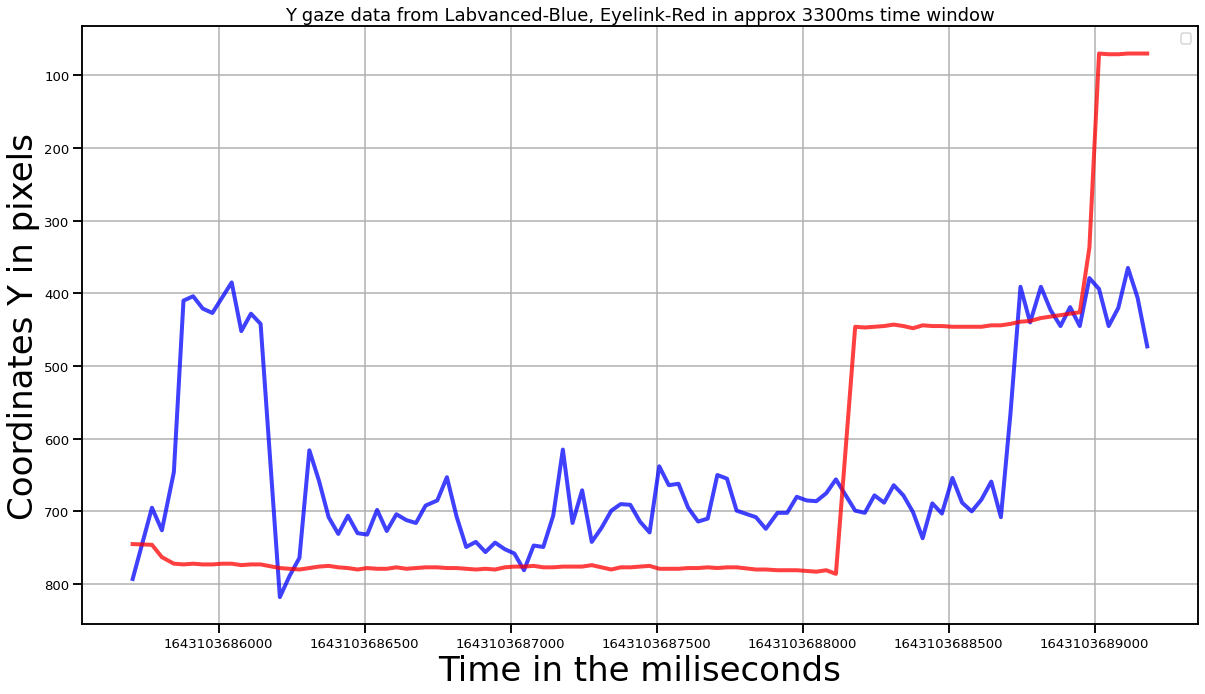

No handles with labels found to put in legend.


p3Blue Line represent timeseries data from Labvanced, the red line represents 
Eyelink and dotted black line represents data after lag cross-correlation corrections.


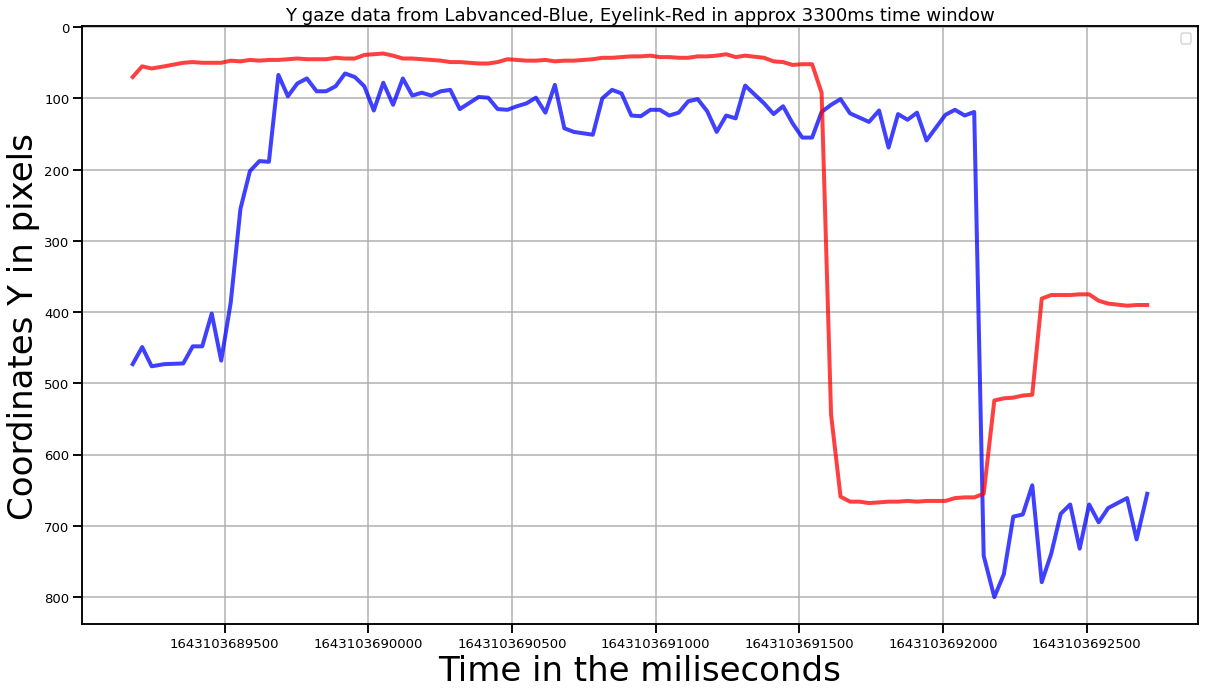

p3Blue Line represent timeseries data from Labvanced, the red line represents 
Eyelink and dotted black line represents data after lag cross-correlation corrections.


No handles with labels found to put in legend.


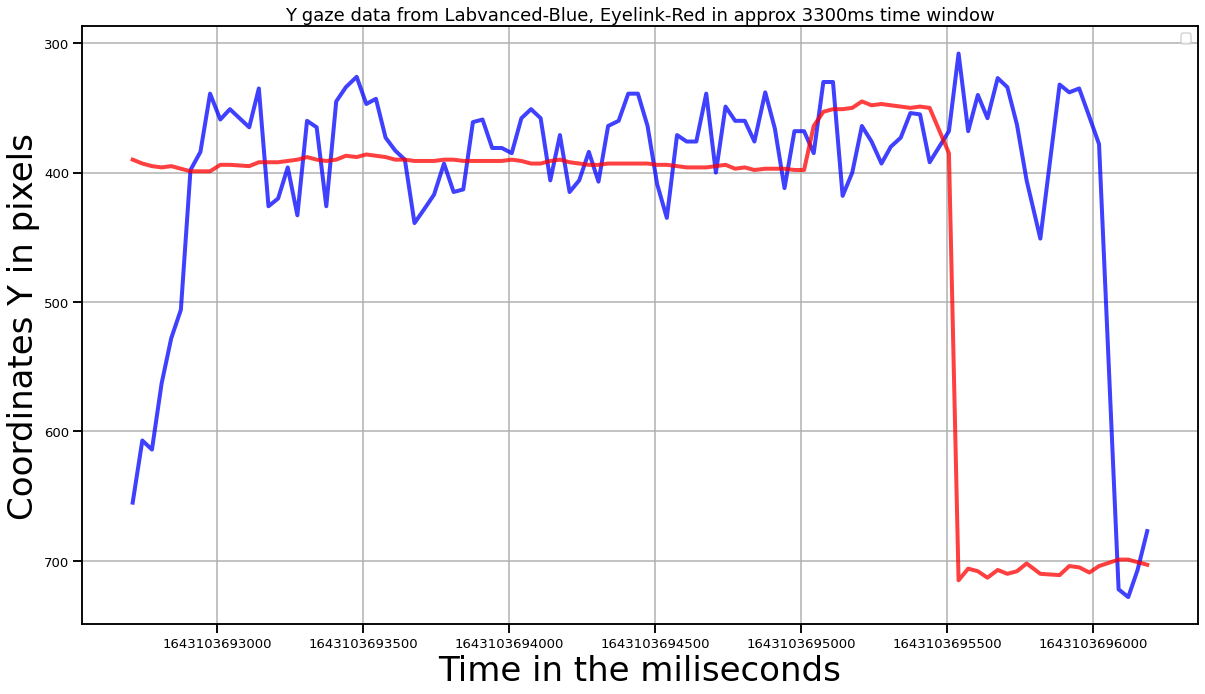

No handles with labels found to put in legend.


p3Blue Line represent timeseries data from Labvanced, the red line represents 
Eyelink and dotted black line represents data after lag cross-correlation corrections.


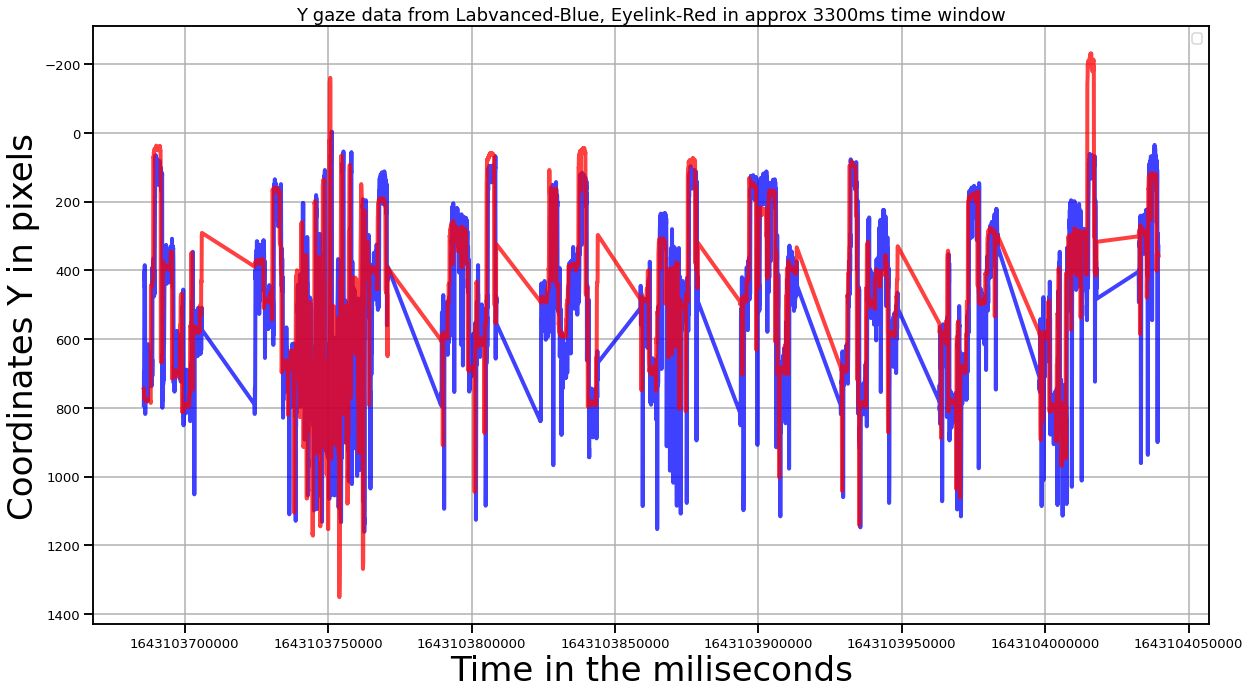

p3Blue Line represent timeseries data from Labvanced, the red line represents 
Eyelink and dotted black line represents data after lag cross-correlation corrections.


In [9]:
# After Synchronization
counter = 13
# for files in sorted(glob.glob("../data/lb_data/timeseries_data/*.csv"),key=os.path.getmtime):
#     lb_data = files  
# for files in sorted(glob.glob("../data/el_data/*.csv"),key=os.path.getmtime):
#     el_data = files  
#     counter = counter + 1
#     # print(counter)
for i in range(3,counter):
    lb = pd.read_csv('../data/lb_data/timeseries_data/p' + str(i) + '_XYTC.csv')

    el = pd.read_csv('../data/el_data/test/p'+ str(i) +'.csv')

    lb = formating_labvanced (lb)
    el = formating_eyelink (el)
    
#     ## DATA SHIFT FUNCTION
#     lb = data_shift (lb, offset)
    lb = lb.set_index('time_lb')
    el = el.set_index('t')

    df_interpolated = interpolation()
    df_interpolated

#     coorection == True
    
    df_interpolated.to_csv('../data/preprocessed/sync_gaze_data_' + str(i) +'.csv')
    timeSeriesSyncPlot(df_interpolated.loc[0:100].time_lb, df_interpolated.loc[0:100].Y_lb, df_interpolated.loc[0:100].Y_el)
    timeSeriesSyncPlot(df_interpolated.loc[100:200].time_lb, df_interpolated.loc[100:200].Y_lb, df_interpolated.loc[100:200].Y_el)
    timeSeriesSyncPlot(df_interpolated.loc[200:300].time_lb, df_interpolated.loc[200:300].Y_lb, df_interpolated.loc[200:300].Y_el)
    
#     timeSeriesSyncPlot(df_interpolated.loc[5800:6037].time_lb, df_interpolated.loc[5800:6037].Y_lb, df_interpolated.loc[5800:6037].Y_el)
    timeSeriesSyncPlot(df_interpolated.time_lb, df_interpolated.Y_lb, df_interpolated.Y_el)
    break

No handles with labels found to put in legend.


From the back of the data


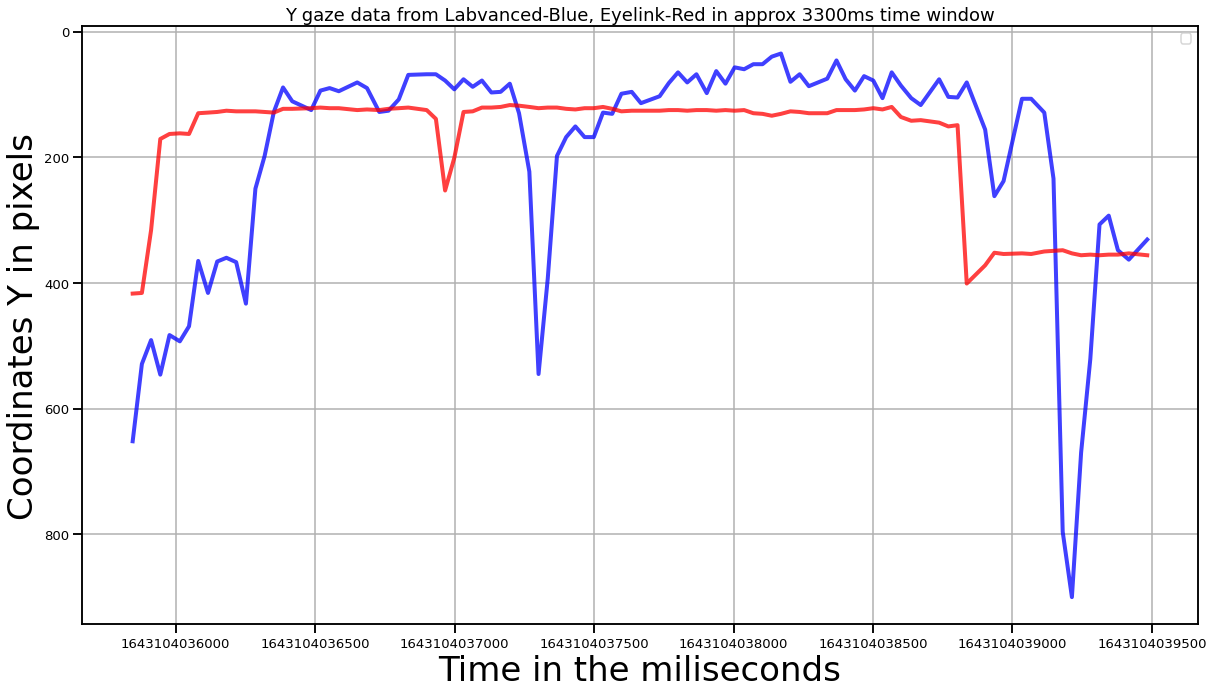

p3Blue Line represent timeseries data from Labvanced, the red line represents 
Eyelink and dotted black line represents data after lag cross-correlation corrections.


No handles with labels found to put in legend.


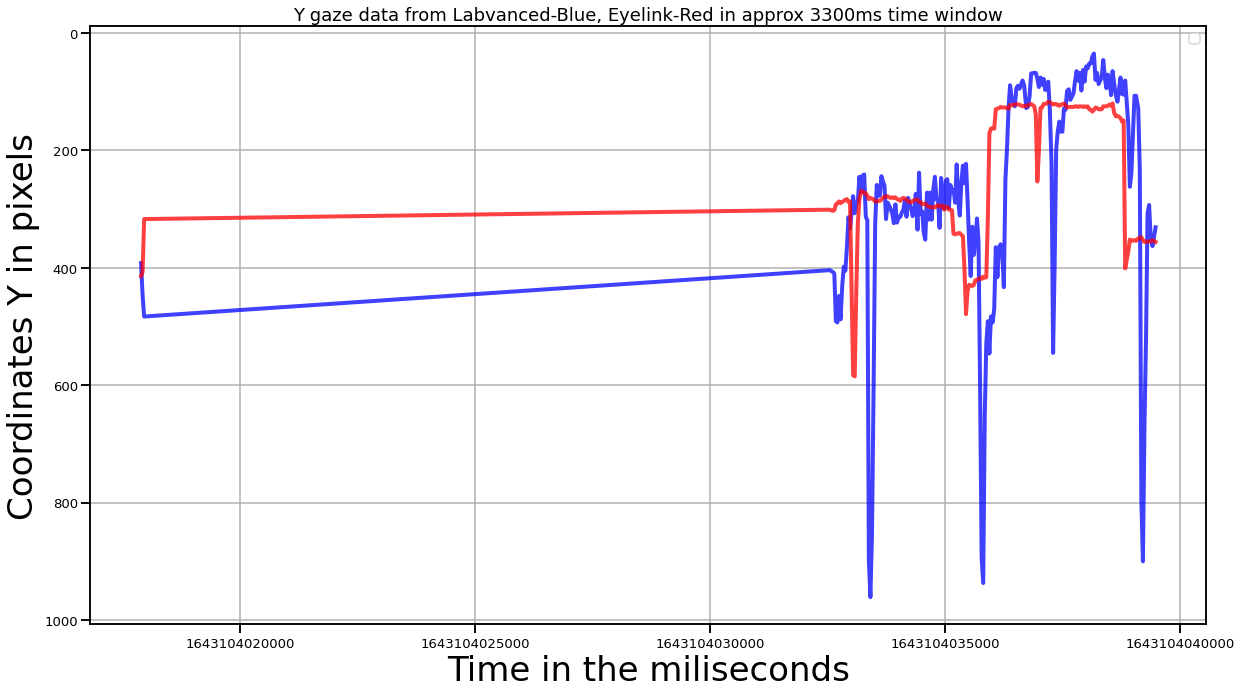

No handles with labels found to put in legend.


p3Blue Line represent timeseries data from Labvanced, the red line represents 
Eyelink and dotted black line represents data after lag cross-correlation corrections.


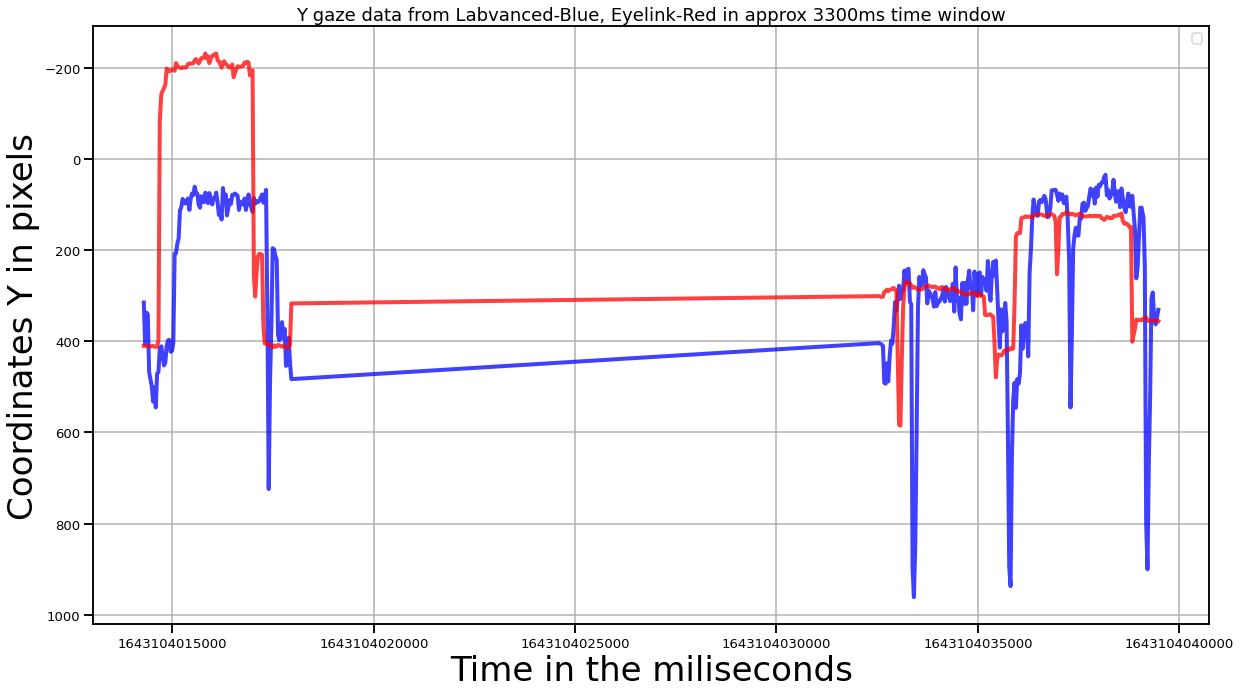

p3Blue Line represent timeseries data from Labvanced, the red line represents 
Eyelink and dotted black line represents data after lag cross-correlation corrections.


In [10]:
print('From the back of the data')
timeSeriesSyncPlot(df_interpolated.tail(100).time_lb, df_interpolated.tail(100).Y_lb, df_interpolated.tail(100).Y_el)
timeSeriesSyncPlot(df_interpolated.tail(200).time_lb, df_interpolated.tail(200).Y_lb, df_interpolated.tail(200).Y_el)
timeSeriesSyncPlot(df_interpolated.tail(300).time_lb, df_interpolated.tail(300).Y_lb, df_interpolated.tail(300).Y_el)